In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
np.random.seed(0)

In [2]:
def fft_analysis(signal):  
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    fft_values = np.fft.fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    return dominant_frequency

In [7]:
def plotear_series_sensores(data_frame):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.flatten()
    for i, column in enumerate(data_frame.columns):
        axs[i].plot(data_frame[column], color='skyblue')
        axs[i].set_title(column)
        axs[i].grid(True)  
    plt.tight_layout()
    plt.show()

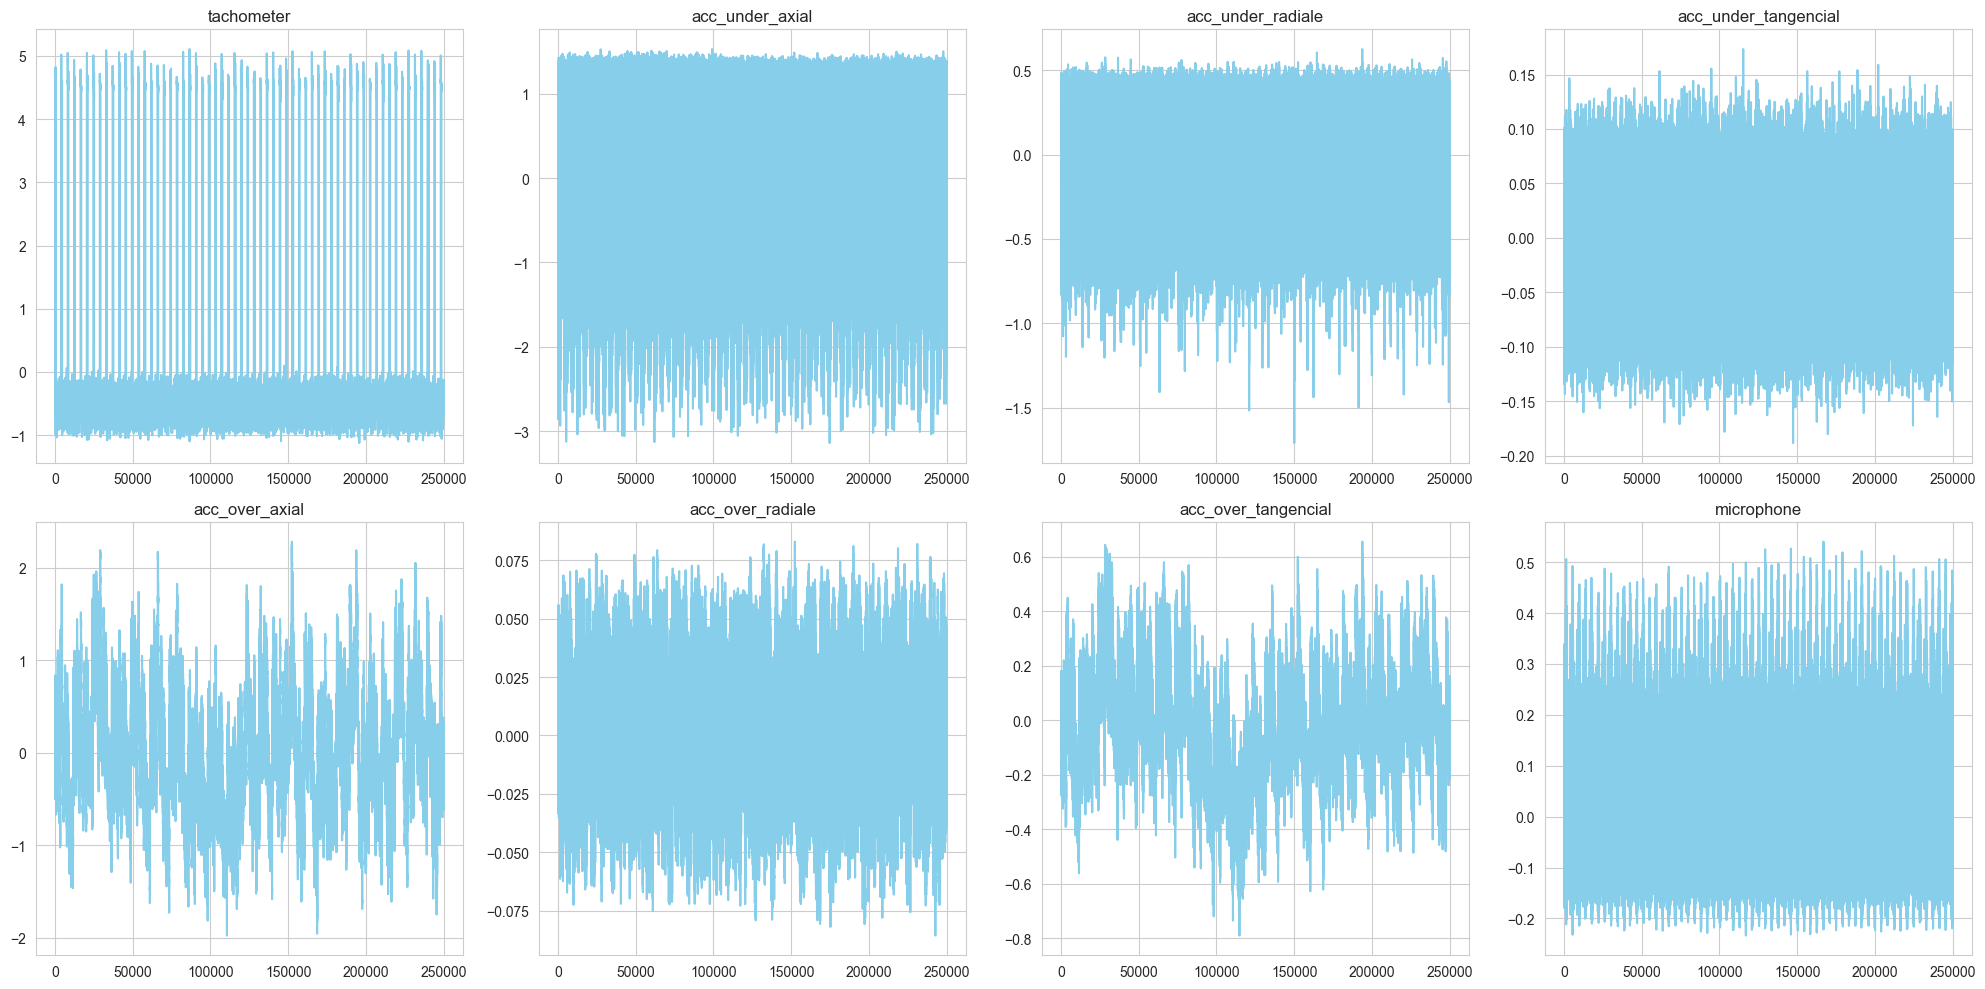

In [8]:
# Medicion normal
normal = pd.read_csv('bearing_fault_detection_reduced/normal/12.288.csv', delimiter=',', header=None)
normal.columns = ['tachometer', 'acc_under_axial', 'acc_under_radiale', 'acc_under_tangencial', 'acc_over_axial', 'acc_over_radiale', 'acc_over_tangencial', 'microphone']
normal.head()
plotear_series_sensores(normal)

### Generar csv

In [5]:
def calcular_estadisticos(df):
    # Verificar que el DataFrame tenga 8 columnas
    if df.shape[1] != 8:
        raise ValueError("El DataFrame debe tener exactamente 8 columnas.")
    
    # Inicializar una lista para almacenar los resultados de cada columna
    fila_resultados = []

    # Calcular los estadísticos para cada columna
    for column in df.columns:
        media = df[column].mean()
        varianza = df[column].var()
        maximo = df[column].max()
        minimo = df[column].min()
        rango = maximo - minimo
        asimetria = df[column].skew()
        curtosis = df[column].kurtosis()
        autocorrelacion = df[column].autocorr(lag=1)
        frecuencia_dominante = fft_analysis(df[column])
        
        # Agregar los resultados de la columna a la lista
        fila_resultados.extend([
            media, varianza, maximo, minimo, rango,
            asimetria, curtosis, autocorrelacion, frecuencia_dominante
        ])

    # Crear un DataFrame con una sola fila y los nombres de las columnas correspondientes
    columnas_resultado = []
    for column in df.columns:
        columnas_resultado.extend([
            f'{column}_Media', f'{column}_Var', f'{column}_Max', f'{column}_Min', f'{column}_Rango',
            f'{column}_Asimetría', f'{column}_Curtosis', f'{column}_Autocorrelación', f'{column}_Frecuencia_dominante'
        ])

    resultado_df = pd.DataFrame([fila_resultados], columns=columnas_resultado)
    
    return resultado_df

In [6]:
def generar_etiqueta(ruta_completa_carpeta):
    # Dividir la ruta en partes
    partes = os.path.normpath(ruta_completa_carpeta).split(os.sep)
    # Eliminar la primera parte ('bearing_fault_detection_reduced')
    partes_sin_primero = partes[1:]
    
    # Unir las partes restantes con guiones bajos
    nombre_unido = '_'.join(partes_sin_primero)
    return nombre_unido

In [7]:
def tabla_error_doble(tipo_error_path): 
    tabla_error_doble = pd.DataFrame()
    categorias = os.listdir(tipo_error_path) # ball, cage, outer
    for categoria in categorias:
        categoria_path = os.path.join(tipo_error_path, categoria)
        pesos = os.listdir(categoria_path)
        for peso in pesos:
            peso_carpeta_path = os.path.join(categoria_path, peso)
            etiqueta = generar_etiqueta(peso_carpeta_path)
            archivos = os.listdir(peso_carpeta_path)
            for archivo in archivos:
                archivo_path = os.path.join(peso_carpeta_path, archivo)
                archivo_datos = pd.read_csv(archivo_path, delimiter=',', header=None)
                archivo_datos.columns = ['tachometer', 'acc_under_axial', 'acc_under_radiale', 'acc_under_tangencial', 'acc_over_axial',
                                   'acc_over_radiale', 'acc_over_tangencial', 'microphone']
                dataframe = calcular_estadisticos(archivo_datos)
                dataframe['Etiqueta'] = etiqueta
                tabla_error_doble = pd.concat([tabla_error_doble, dataframe], ignore_index=True)
    return tabla_error_doble

In [8]:
def tabla_error_simple(tipo_error_path): 
    tabla_error_simple = pd.DataFrame()
    pesos = os.listdir(tipo_error_path) 
    for peso in pesos:
        peso_carpeta_path = os.path.join(tipo_error_path, peso)
        etiqueta = generar_etiqueta(peso_carpeta_path)
        archivos = os.listdir(peso_carpeta_path)
        for archivo in archivos:
            archivo_path = os.path.join(peso_carpeta_path, archivo)
            archivo_datos = pd.read_csv(archivo_path, delimiter=',', header=None)
            archivo_datos.columns = ['tachometer', 'acc_under_axial', 'acc_under_radiale', 'acc_under_tangencial', 'acc_over_axial',
                               'acc_over_radiale', 'acc_over_tangencial', 'microphone']
            dataframe = calcular_estadisticos(archivo_datos)
            dataframe['Etiqueta'] = etiqueta
            tabla_error_simple = pd.concat([tabla_error_simple, dataframe], ignore_index=True)
    return tabla_error_simple

In [9]:
def tabla_error_normal(tipo_error_path): 
    tabla_error_normal = pd.DataFrame()
    archivos = os.listdir(tipo_error_path) 
    for archivo in archivos:
        archivo_path = os.path.join(tipo_error_path, archivo)
        archivo_datos = pd.read_csv(archivo_path, delimiter=',', header=None)
        archivo_datos.columns = ['tachometer', 'acc_under_axial', 'acc_under_radiale', 'acc_under_tangencial', 'acc_over_axial',
                           'acc_over_radiale', 'acc_over_tangencial', 'microphone']
        dataframe = calcular_estadisticos(archivo_datos)
        dataframe['Etiqueta'] = 'normal'
        tabla_error_normal = pd.concat([tabla_error_normal, dataframe], ignore_index=True)
    return tabla_error_normal

Diferentes estructuras dentro de los datos:
- Normal: directamente los csv
- SIMPLE: una carpeta antes de los csv (Horizontal, imbalance, vertical)
- DOBLE: dos carpetas antes de los csv (Underhang, overhang)

#### Generar la tabla final (todos los fallos)

In [ ]:
tabla_combinada = pd.DataFrame()
path_principal = 'bearing_fault_detection'
errores = os.listdir(path_principal)
for error in errores:
    tipo_error_path = os.path.join(path_principal, error)
    if error == 'underhang' or error == 'overhang':
        tabla = tabla_error_doble(tipo_error_path)
    if error == 'horizontal-misalignment' or error == 'imbalance' or error == 'vertical-misalignment':
        tabla = tabla_error_simple(tipo_error_path)
    if error == 'normal':
        tabla = tabla_error_normal(tipo_error_path)
    tabla_combinada = pd.concat([tabla_combinada, tabla], ignore_index=True)

In [ ]:
tabla_combinada.to_csv('Data_final.csv', index=False)

#### Reducción de las clases de errores a 5

In [20]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]

In [21]:
horizontal_misalignment = ['horizontal-misalignment_0.5mm', 'horizontal-misalignment_1.0mm', 'horizontal-misalignment_1.5mm', 'horizontal-misalignment_2.0mm']
vertical_misalignment = ['vertical-misalignment_0.51mm', 'vertical-misalignment_0.63mm', 'vertical-misalignment_1.27mm', 'vertical-misalignment_1.40mm', 'vertical-misalignment_1.78mm', 'vertical-misalignment_1.90mm']
imbalance = ['imbalance_6g', 'imbalance_10g', 'imbalance_20g', 'imbalance_15g', 'imbalance_25g', 'imbalance_30g', 'imbalance_35g']
overhang = ['overhang_ball_fault_0g','overhang_ball_fault_6g','overhang_ball_fault_20g','overhang_ball_fault_35g', 'overhang_cage_fault_0g','overhang_cage_fault_6g','overhang_cage_fault_20g','overhang_cage_fault_35g', 'overhang_outer_race_0g','overhang_outer_race_6g','overhang_outer_race_20g','overhang_outer_race_35g']
underhang = ['underhang_ball_fault_0g','underhang_ball_fault_6g','underhang_ball_fault_20g','underhang_ball_fault_35g', 'underhang_cage_fault_0g','underhang_cage_fault_6g','underhang_cage_fault_20g','underhang_cage_fault_35g', 'underhang_outer_race_0g','underhang_outer_race_6g','underhang_outer_race_20g','underhang_outer_race_35g']

label_mapping = {}

for label in horizontal_misalignment:
    label_mapping[label] = 'horizontal_misalignment'

for label in vertical_misalignment:
    label_mapping[label] = 'vertical_misalignment'

for label in imbalance:
    label_mapping[label] = 'imbalance'

for label in overhang:
    label_mapping[label] = 'overhang'

for label in underhang:
    label_mapping[label] = 'underhang'

y_mapped = [label_mapping[label] if label != 'normal' else 'normal' for label in y]

# Ver el resultado
print(y_mapped)

['horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 'horizontal_misalignment', 

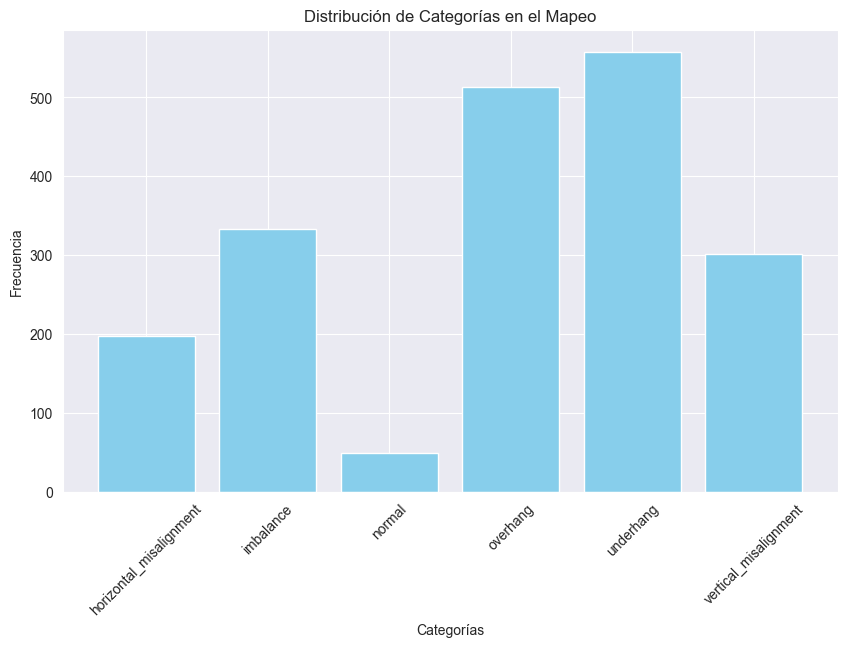

In [22]:
counts = Counter(y_mapped)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Distribución de Categorías en el Mapeo')
plt.xticks(rotation=45)
plt.show()

In [18]:
df_nuevo = X
df_nuevo['Etiqueta'] = y_mapped
df_nuevo.to_csv('Data_simplificado.csv', index=False)

### Análisis de variables

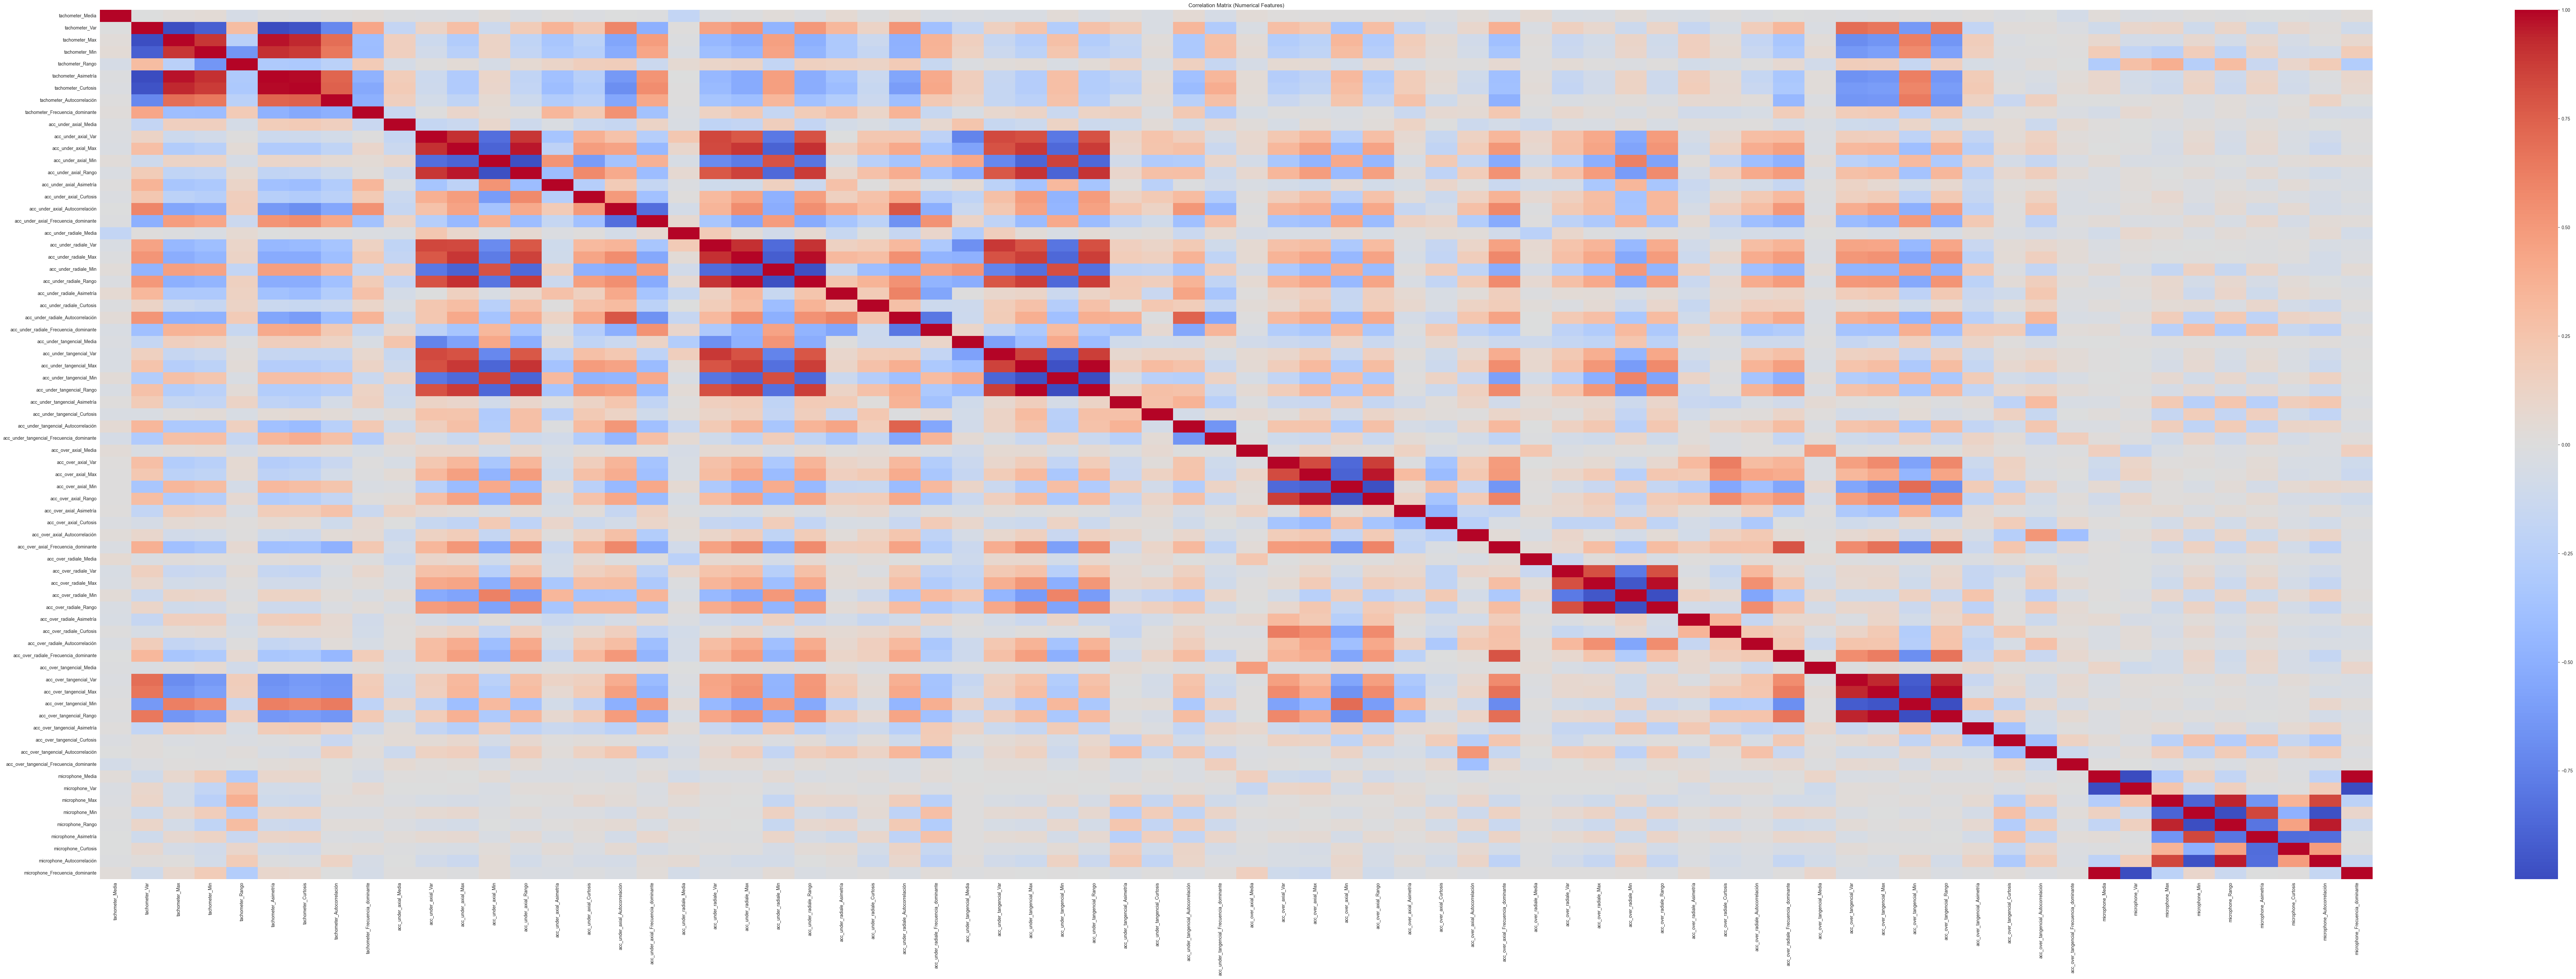

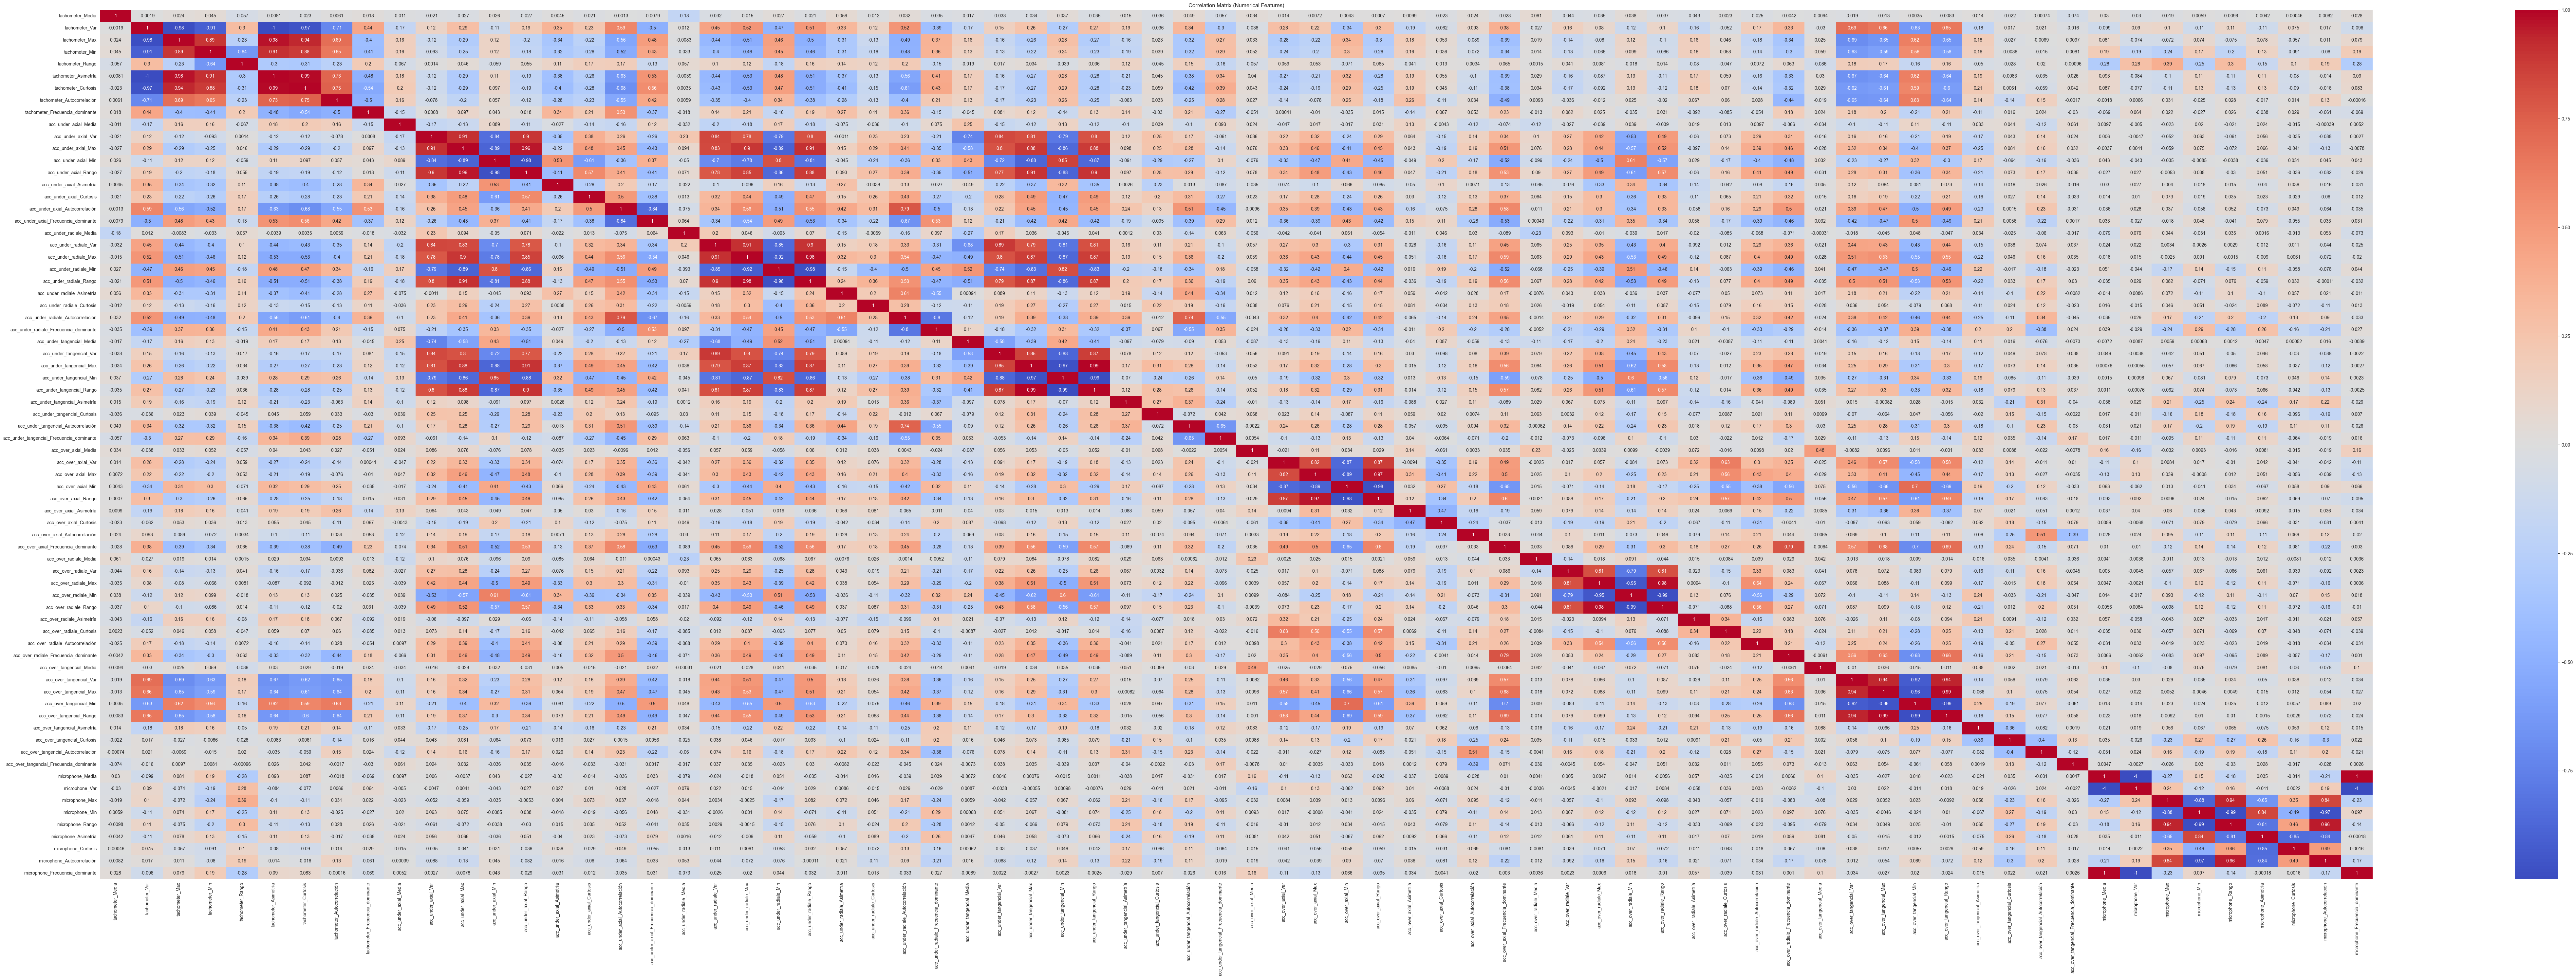


Highly correlated feature pairs (|correlation| > 0.9):
tachometer_Var & tachometer_Max: -0.985
tachometer_Var & tachometer_Min: -0.912
tachometer_Var & tachometer_Asimetría: -0.995
tachometer_Var & tachometer_Curtosis: -0.968
tachometer_Max & tachometer_Asimetría: 0.975
tachometer_Max & tachometer_Curtosis: 0.936
tachometer_Min & tachometer_Asimetría: 0.907
tachometer_Asimetría & tachometer_Curtosis: 0.988
acc_under_axial_Var & acc_under_axial_Max: 0.910
acc_under_axial_Max & acc_under_axial_Rango: 0.962
acc_under_axial_Max & acc_under_radiale_Rango: 0.913
acc_under_axial_Min & acc_under_axial_Rango: -0.979
acc_under_axial_Rango & acc_under_tangencial_Max: 0.906
acc_under_axial_Rango & acc_under_tangencial_Rango: 0.901
acc_under_radiale_Var & acc_under_radiale_Max: 0.908
acc_under_radiale_Var & acc_under_radiale_Rango: 0.901
acc_under_radiale_Max & acc_under_radiale_Min: -0.917
acc_under_radiale_Max & acc_under_radiale_Rango: 0.980
acc_under_radiale_Min & acc_under_radiale_Rango: -0.9

In [10]:
plt.figure(figsize=(90, 30))
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(90, 30))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features)')
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (|correlation| > 0.9):")
correlation_matrix = X.corr()
high_corr = np.where(np.abs(correlation_matrix) > 0.9)
for i, j in zip(*high_corr):
    if i < j:
        print(f"{correlation_matrix.index[i]} & {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

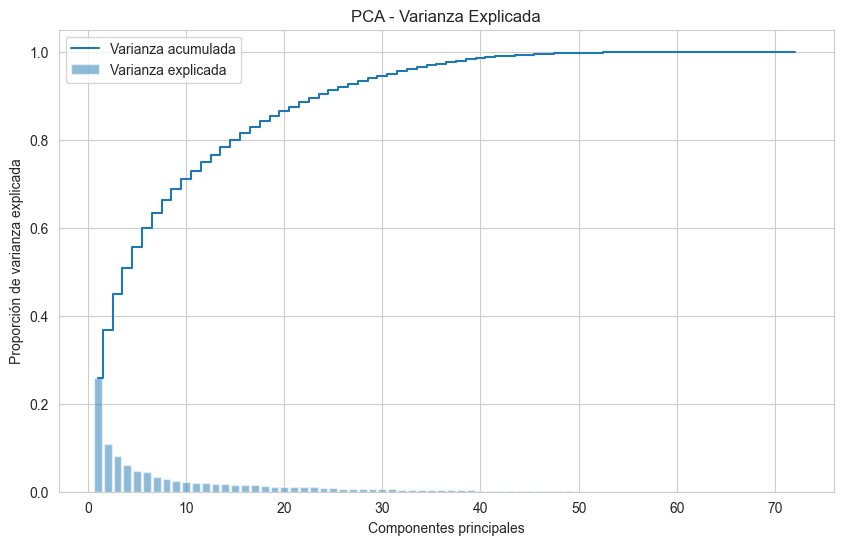

Varianza explicada por componente:
Componente 1: 0.2592
Componente 2: 0.1085
Componente 3: 0.0812
Componente 4: 0.0603
Componente 5: 0.0471
Componente 6: 0.0438
Componente 7: 0.0338
Componente 8: 0.0282
Componente 9: 0.0250
Componente 10: 0.0225
Componente 11: 0.0199
Componente 12: 0.0195
Componente 13: 0.0171
Componente 14: 0.0169
Componente 15: 0.0159
Componente 16: 0.0155
Componente 17: 0.0145
Componente 18: 0.0127
Componente 19: 0.0116
Componente 20: 0.0112
Componente 21: 0.0107
Componente 22: 0.0101
Componente 23: 0.0096
Componente 24: 0.0090
Componente 25: 0.0081
Componente 26: 0.0073
Componente 27: 0.0071
Componente 28: 0.0068
Componente 29: 0.0060
Componente 30: 0.0058
Componente 31: 0.0052
Componente 32: 0.0050
Componente 33: 0.0048
Componente 34: 0.0044
Componente 35: 0.0043
Componente 36: 0.0040
Componente 37: 0.0037
Componente 38: 0.0034
Componente 39: 0.0031
Componente 40: 0.0025
Componente 41: 0.0019
Componente 42: 0.0018
Componente 43: 0.0016
Componente 44: 0.0014
Compon

In [11]:
# Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)


plt.figure(figsize=(10, 6))
plt.bar(range(1, len(varianza_explicada) + 1), varianza_explicada, alpha=0.5, align='center', label='Varianza explicada')
plt.step(range(1, len(varianza_acumulada) + 1), varianza_acumulada, where='mid', label='Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Proporción de varianza explicada')
plt.title('PCA - Varianza Explicada')
plt.legend(loc='best')
plt.show()


print("Varianza explicada por componente:")
for i, var in enumerate(varianza_explicada, start=1):
    print(f"Componente {i}: {var:.4f}")

n_componentes_optimos = np.argmax(varianza_acumulada >= 0.9) + 1
print(f"\nNúmero óptimo de componentes para capturar el 90% de la varianza: {n_componentes_optimos}")

pca_optimo = PCA(n_components=n_componentes_optimos)
X_reducido = pca_optimo.fit_transform(X_scaled)

print(f"Conjunto de datos reducido a {n_componentes_optimos} componentes principales.")
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()

In [27]:
# Obtener la matriz de componentes
loadings = pca.components_

# Crear un DataFrame para visualizar las contribuciones
loadings_df = pd.DataFrame(loadings, columns=X.columns)

In [28]:
loadings_df

tachometer_Media  tachometer_Var  tachometer_Max  tachometer_Min  \
0          -0.004358    1.485011e-01       -0.146257       -0.136721   
1          -0.010994   -2.121788e-01        0.201552        0.214671   
2          -0.003581   -3.067321e-02        0.044003       -0.008450   
3           0.001768   -1.412781e-01        0.140704        0.116198   
4           0.048906   -3.585212e-02        0.040159        0.071434   
..               ...             ...             ...             ...   
67         -0.000000   -7.140122e-14       -0.110437        0.140378   
68         -0.000000   -1.233798e-13        0.118304       -0.150379   
69          0.000000   -1.341740e-13       -0.223641        0.284275   
70         -0.000000   -1.895934e-13        0.161449       -0.205221   
71          0.000000    1.661478e-13        0.018460       -0.023465   

    tachometer_Rango  tachometer_Asimetría  tachometer_Curtosis  \
0           0.047112         -1.507275e-01        -1.500965e-01   
1          -0.122044          2.149038e-01         2.166779e-01   
2           0.093679          2.282599e-02         8.100889e-03   
3          -0.011973          1.532365e-01         1.677126e-01   
4          -0.086659          1.698182e-02        -9.780423e-03   
..               ...                   ...                  ...   
67          0.064537         -4.665018e-14        -8.798517e-15   
68         -0.069134         -3.294240e-14        -6.331394e-14   
69          0.130691         -3.512607e-13         1.800782e-13   
70         -0.094347         -3.761991e-13         1.701556e-13   
71         -0.010788          2.518519e-13        -9.360655e-14   

    tachometer_Autocorrelación  tachometer_Frecuencia_dominante  \
0                -1.206152e-01                     6.757350e-02   
1                 1.756849e-01                    -1.301714e-01   
2                 1.059208e-01                    -4.645343e-03   
3                 1.718721e-01                    -1.760611e-01   
4                 8.067511e-02                     4.483036e-02   
..                         ...                              ...   
67                7.459311e-17                    -1.586405e-15   
68                2.357489e-15                    -1.694825e-15   
69                2.364428e-15                    -5.689893e-16   
70               -4.446964e-15                     9.853229e-16   
71               -9.215718e-17                    -5.158634e-16   

    acc_under_axial_Media  ...  acc_over_tangencial_Frecuencia_dominante  \
0           -4.217490e-02  ...                              4.649451e-03   
1            2.113947e-02  ...                              1.934608e-02   
2           -2.975374e-02  ...                             -3.932659e-02   
3            8.406445e-02  ...                              4.925309e-03   
4            4.394112e-02  ...                             -6.957044e-02   
..                    ...  ...                                       ...   
67           8.844921e-16  ...                              7.329207e-16   
68           1.563528e-15  ...                              9.159340e-16   
69           1.260493e-15  ...                             -6.591949e-17   
70          -3.770855e-16  ...                              5.967449e-16   
71           2.702374e-17  ...                              9.439064e-16   

    microphone_Media  microphone_Var  microphone_Max  microphone_Min  \
0      -1.509956e-02    1.394039e-02        0.009437       -0.005826   
1       6.255960e-02   -5.701181e-02       -0.133070        0.144726   
2      -9.073064e-02    8.225062e-02        0.293739       -0.315823   
3      -1.124105e-01    1.095871e-01        0.151060       -0.145668   
4       1.632277e-01   -1.621115e-01       -0.097751        0.070026   
..               ...             ...             ...             ...   
67     -5.208819e-13   -6.668138e-13       -0.119256        0.308221   
68     -3.790284e-13   -3.208250e-13    

In [29]:
# Lista para almacenar los nombres de las variables con alta contribución
high_contribution_variables = []

# Filtrar y seleccionar las 3 mayores contribuciones absolutas para cada componente
for i in range(19):  # Iterar sobre las primeras 19 componentes
    print(f"Componente Principal {i+1}:")
    
    # Ordenar las cargas por su valor absoluto y seleccionar las 3 más altas
    high_contrib = loadings_df.loc[i].abs().sort_values(ascending=False).head(3)
    print(high_contrib)
    print("\n")
    
    # Agregar a la lista solo si no está ya en la lista
    for variable in high_contrib.index:
        if variable not in high_contribution_variables:
            high_contribution_variables.append(variable)

# Mostrar todas las variables que tuvieron una alta contribución
print("Variables con alta contribución en las primeras 19 componentes principales:")
sorted_list = sorted(high_contribution_variables)
print(sorted_list)
print(f"Total de variables seleccionadas: {len(high_contribution_variables)}")

Componente Principal 1:
acc_under_radiale_Max      0.213846
acc_under_radiale_Rango    0.213717
acc_under_radiale_Min      0.204325
Name: 0, dtype: float64


Componente Principal 2:
tachometer_Curtosis     0.216678
tachometer_Asimetría    0.214904
tachometer_Min          0.214671
Name: 1, dtype: float64


Componente Principal 3:
microphone_Autocorrelación    0.317712
microphone_Rango              0.317233
microphone_Min                0.315823
Name: 2, dtype: float64


Componente Principal 4:
acc_over_axial_Max      0.317911
acc_over_axial_Rango    0.309504
acc_over_axial_Var      0.308063
Name: 3, dtype: float64


Componente Principal 5:
acc_under_radiale_Autocorrelación    0.240905
acc_over_radiale_Max                 0.226793
acc_over_radiale_Var                 0.224428
Name: 4, dtype: float64


Componente Principal 6:
microphone_Frecuencia_dominante    0.468451
microphone_Var                     0.466421
microphone_Media                   0.461041
Name: 5, dtype: float64


Compone

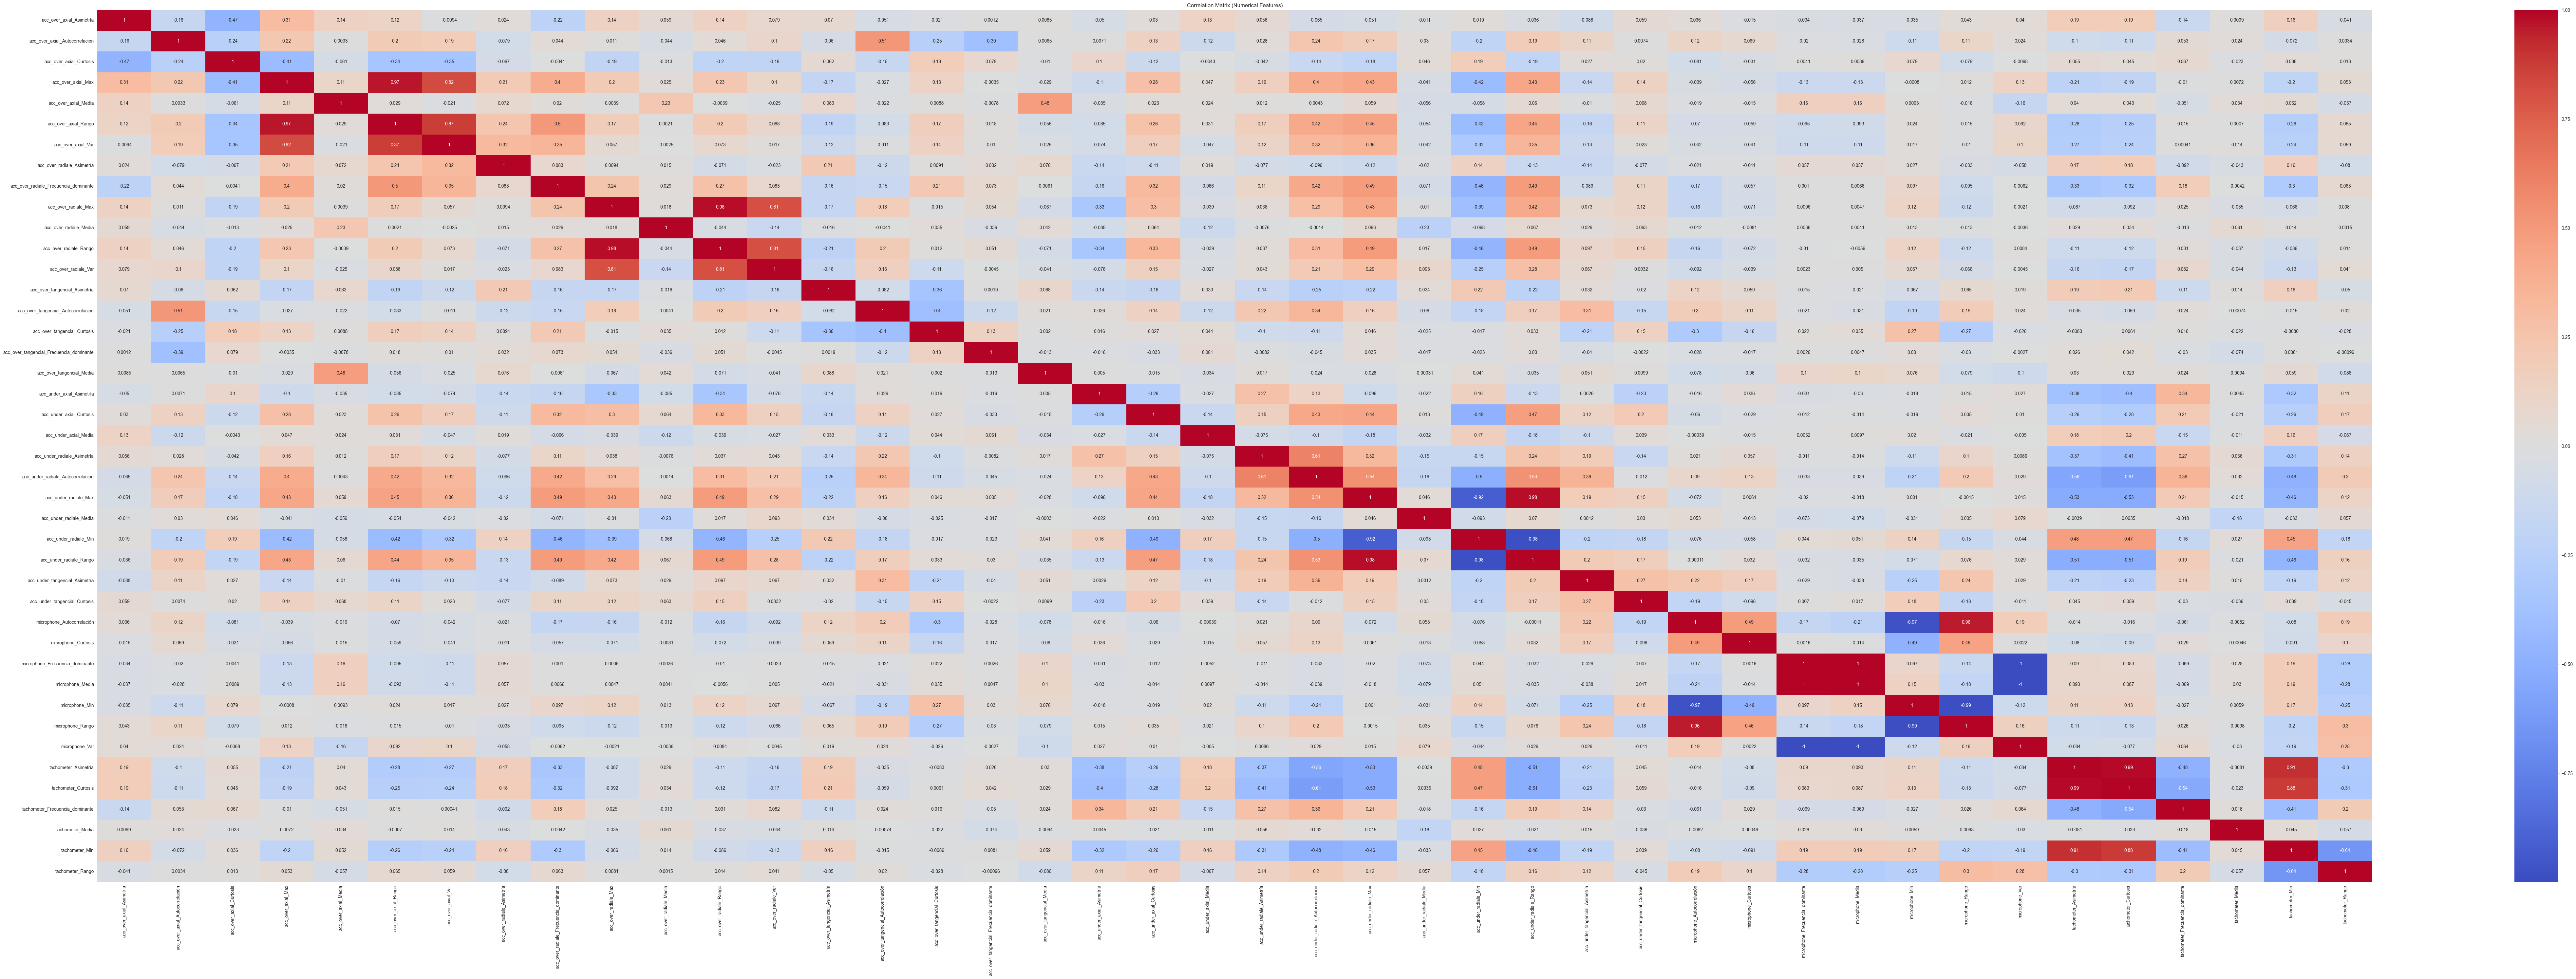


Highly correlated feature pairs (|correlation| > 0.9):
acc_over_axial_Max & acc_over_axial_Rango: 0.965
acc_over_radiale_Max & acc_over_radiale_Rango: 0.984
acc_under_radiale_Max & acc_under_radiale_Min: -0.917
acc_under_radiale_Max & acc_under_radiale_Rango: 0.980
acc_under_radiale_Min & acc_under_radiale_Rango: -0.978
microphone_Autocorrelación & microphone_Min: -0.973
microphone_Autocorrelación & microphone_Rango: 0.959
microphone_Frecuencia_dominante & microphone_Media: 0.998
microphone_Frecuencia_dominante & microphone_Var: -0.999
microphone_Media & microphone_Var: -0.999
microphone_Min & microphone_Rango: -0.991
tachometer_Asimetría & tachometer_Curtosis: 0.988
tachometer_Asimetría & tachometer_Min: 0.907


In [31]:
variables_pca = sorted_list
X_reducida = X[variables_pca]

plt.figure(figsize=(90, 30))
sns.heatmap(X_reducida.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features)')
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (|correlation| > 0.9):")
correlation_matrix = X_reducida.corr()
high_corr = np.where(np.abs(correlation_matrix) > 0.9)
for i, j in zip(*high_corr):
    if i < j:
        print(f"{correlation_matrix.index[i]} & {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

In [2]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]

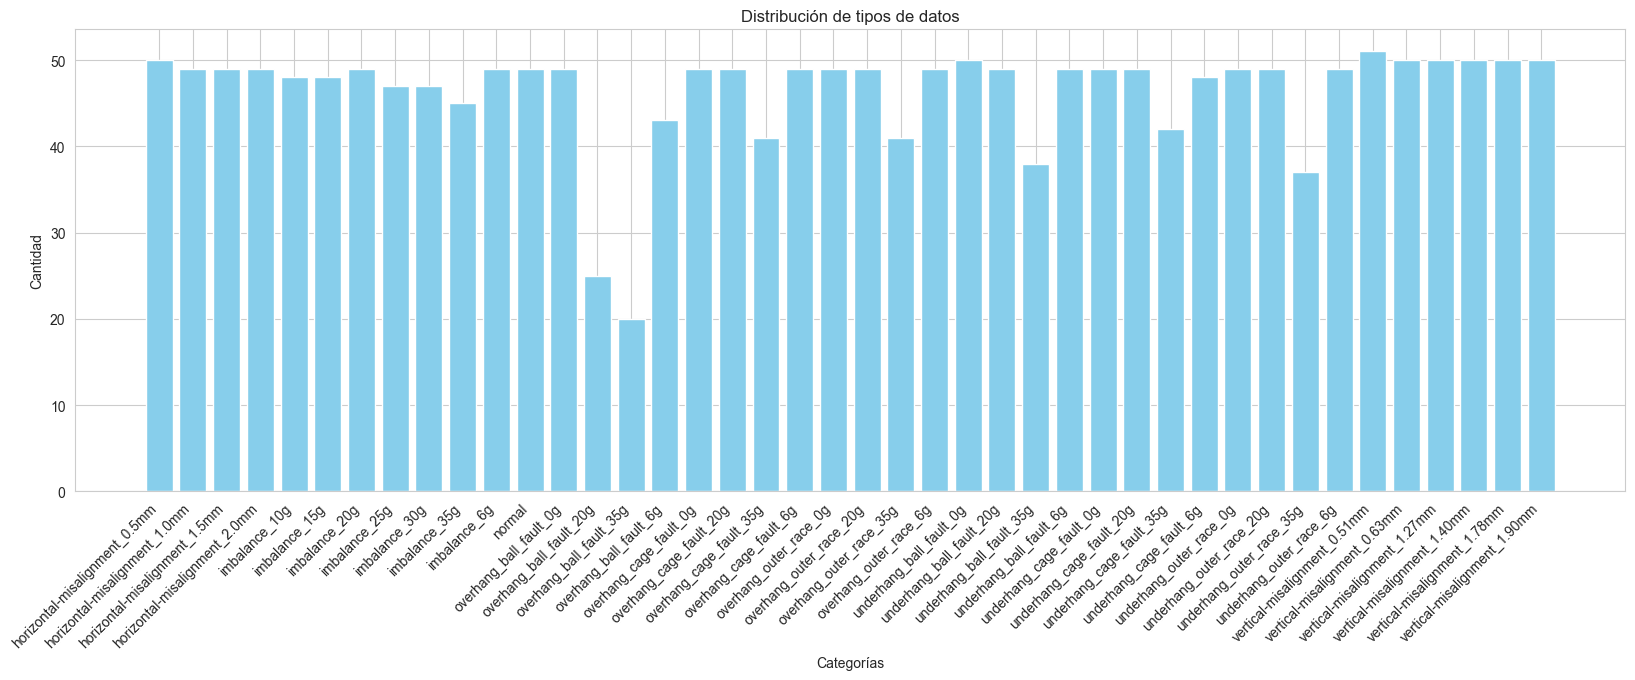

In [4]:
# Contar las categorías
counts = Counter(y)

# Crear el gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.xlabel('Categorías')
plt.ylabel('Cantidad')
plt.title('Distribución de tipos de datos')

# Ajustar los xticks
plt.xticks(rotation=45, ha='right', fontsize=10)

# Mostrar el gráfico
plt.show()
